In [1]:
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt

## word2vec Subsampling Frequent Words

Each word in the training set is discarded with the probability computed by the form: $P(w_i) = 1 - \sqrt{\frac{threshold}{freq(w_i)}}$

In [2]:
def prob_func_factory(threshold):
    return lambda freq: max(0, 1 - math.sqrt(threshold / freq))

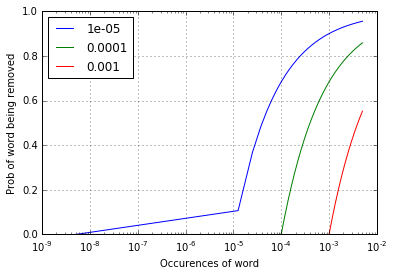

In [6]:
thresholds = [1e-5, 1e-4, 1e-3]

for threshold in thresholds:
    prob_fn = prob_func_factory(threshold)
    freqs = range(1, 1000000, 2500)
    freqs_sum = float(sum(freqs))
    freqs = [freq / freqs_sum for freq in freqs]
    probs = [prob_fn(freq) for freq in freqs]
    
    plt.semilogx(freqs, probs, label=threshold)
    
plt.ylabel('Prob of word being removed')
plt.xlabel('Occurences of word')
plt.legend(loc='upper left'); plt.grid(); plt.show()

This formula was chosen because it aggresively subsamples words whose frequency is higher than the set threshold.

## Trump dataset processing

In [59]:
import os
import re
import nltk
import csv
import numpy
import string
import codecs
import pandas

In [64]:
# filepaths
CORPORA_DIR = './corpora/presidential-transcripts-raw/'
CLEAN_FILE_NAME = './corpora/presidential-clean.txt'

# regexps
with codecs.open(CLEAN_FILE_NAME, 'w', encoding='ascii', errors='ignore') as out:
    for root_dir, dirs, files in os.walk(CORPORA_DIR):
        print 'Exploring: ', root_dir
        for file_name in files:
            if not re.match('\.DS_Store', file_name):
                file_path = os.path.join(root_dir, file_name)
                with open(file_path) as fd:
                    # read entire file
                    raw_content = [line.decode('ascii', errors='replace') for line in fd.readlines()]

                    # translate to lowercase
                    lower_contents = [text.lower() for text in raw_content]

                    # tokenizer speech into sentences
                    for fragment in lower_contents:
                        [out.write(line.strip() + '\n') for line in nltk.tokenize.sent_tokenize(fragment)]

Exploring:  ./corpora/presidential-transcripts-raw/
Exploring:  ./corpora/presidential-transcripts-raw/coolidge
Exploring:  ./corpora/presidential-transcripts-raw/tyler
Exploring:  ./corpora/presidential-transcripts-raw/wilson
Exploring:  ./corpora/presidential-transcripts-raw/ford
Exploring:  ./corpora/presidential-transcripts-raw/pierce
Exploring:  ./corpora/presidential-transcripts-raw/lincoln
Exploring:  ./corpora/presidential-transcripts-raw/washington
Exploring:  ./corpora/presidential-transcripts-raw/reagan
Exploring:  ./corpora/presidential-transcripts-raw/hoover
Exploring:  ./corpora/presidential-transcripts-raw/jefferson
Exploring:  ./corpora/presidential-transcripts-raw/bharrison
Exploring:  ./corpora/presidential-transcripts-raw/monroe
Exploring:  ./corpora/presidential-transcripts-raw/carter
Exploring:  ./corpora/presidential-transcripts-raw/taft
Exploring:  ./corpora/presidential-transcripts-raw/madison
Exploring:  ./corpora/presidential-transcripts-raw/roosevelt
Explorin

In [72]:
# filepaths
CORPORA_DIR = './corpora/reviews/'
CLEAN_FILE_NAME = './corpora/reviews-clean.txt'

# regexps
with codecs.open(CLEAN_FILE_NAME, 'w', encoding='ascii', errors='ignore') as out:
    for root_dir, dirs, files in os.walk(CORPORA_DIR):
        print 'Exploring: ', root_dir
        for file_name in files:
            if not re.match('\.DS_Store', file_name):
                file_path = os.path.join(root_dir, file_name)
                
                with open(file_path) as fd:
                    csv_reader = csv.reader(fd)
                    next(csv_reader, None)
                    # read and decodeentire file
                    raw_content = [row[-1].decode('utf8', errors='replace') for row in csv_reader]
                    
                    # remove new lines
                    clean_content = [re.sub(r'[\n\r ]+', ' ', line) for line in raw_content]

                    # translate to lowercase
                    lower_contents = [text.lower() for text in raw_content]

                    # tokenizer speech into sentences
                    for fragment in lower_contents:
                        [out.write(line.strip() + '\n') for line in nltk.tokenize.sent_tokenize(fragment)]

Exploring:  ./corpora/reviews/
